In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import re

In [2]:
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)

In [3]:
filepath = './data/zj_fraud_fp_0501_new.csv'
_start = time.time()
total_df = pd.read_csv(filepath, dtype={'fraud_inacc_certno_first_6': str})
print('time consuming:', time.time()-_start)

time consuming: 24.45371985435486


In [4]:
total_df = total_df.drop([867067])
assert total_df.shape == (867067, 370)

In [5]:
total_df = total_df[total_df['dt']==20190501]
total_df.reset_index(drop=True, inplace=True)
print(total_df.shape)

(294352, 370)


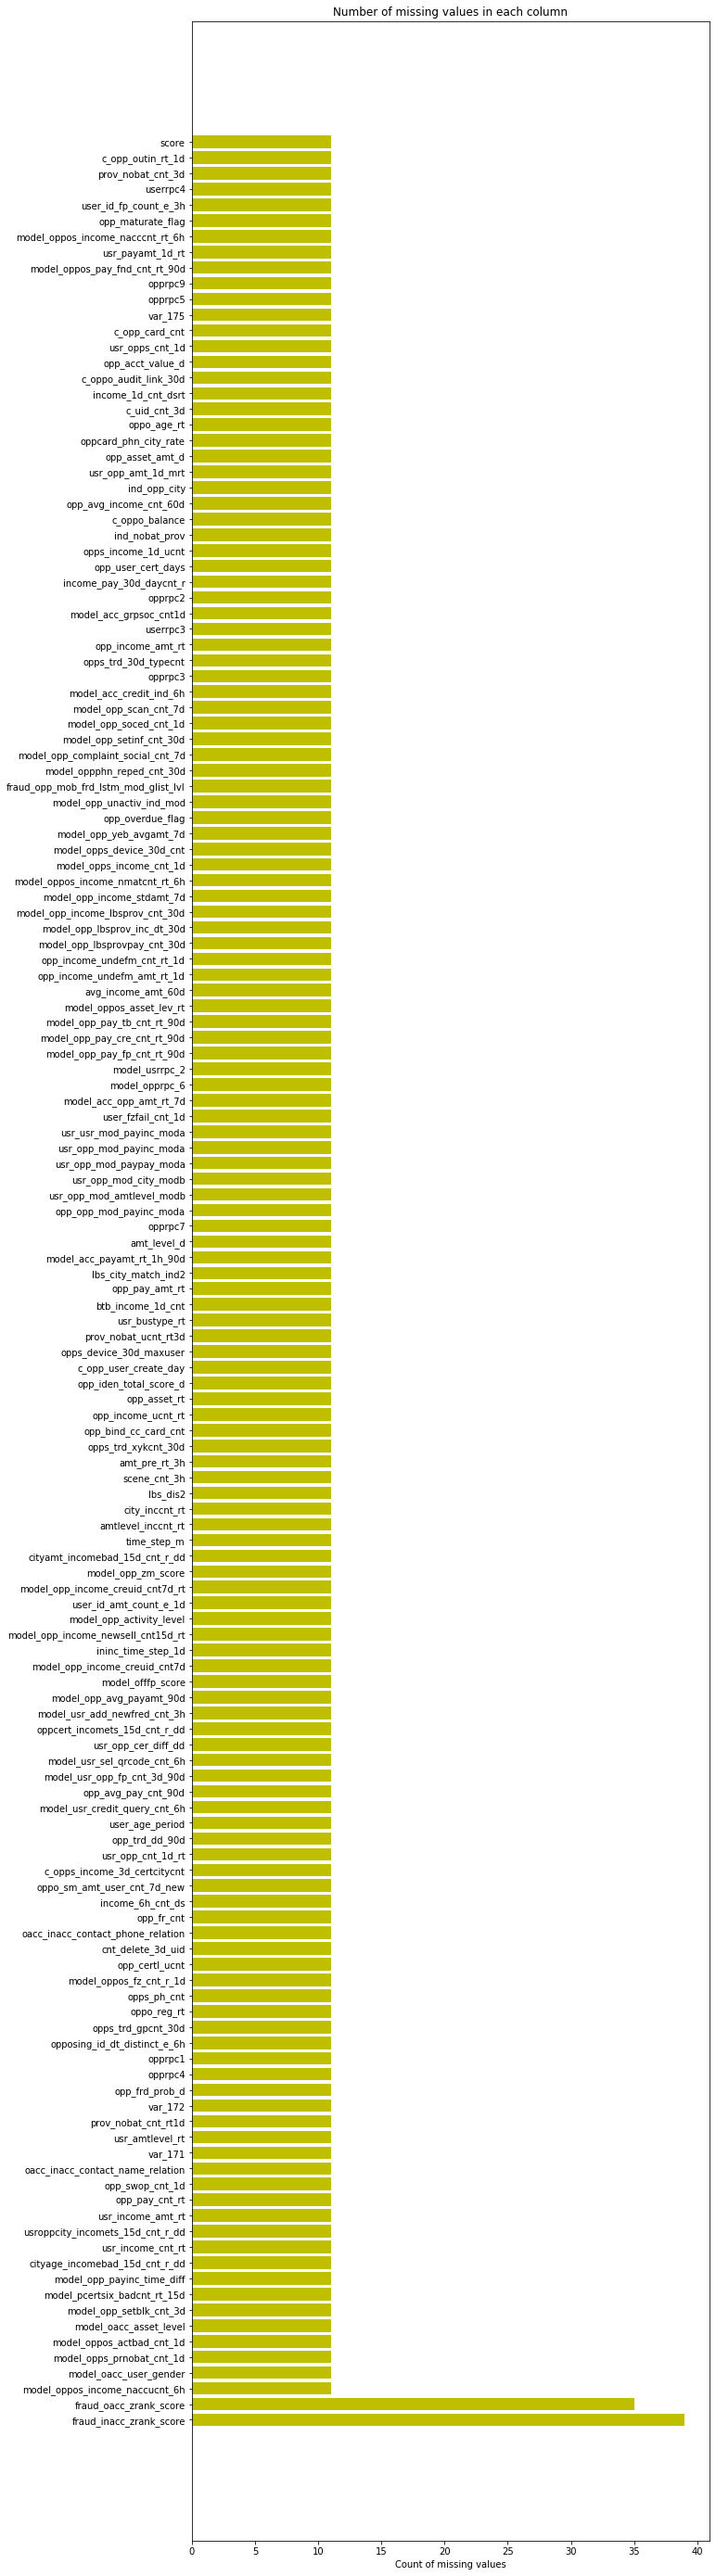

In [6]:
# 属性缺失情况
missing_df = total_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df[missing_df['missing_count']<100000]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,50))
rects = ax.barh(ind, missing_df.missing_count.values, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [7]:
# 删除amt这一列
total_df = total_df.drop(['amt'], axis=1)
print(total_df.shape)

(294352, 369)


In [8]:
# 删除有很多缺失值的那几行
print(sum(total_df.flag_case))
total_df.dropna(subset=['score'], axis=0, inplace=True)
print(total_df.shape)
print(sum(total_df.flag_case))  # 说明黑样本没被删除

44.0
(294341, 369)
44.0


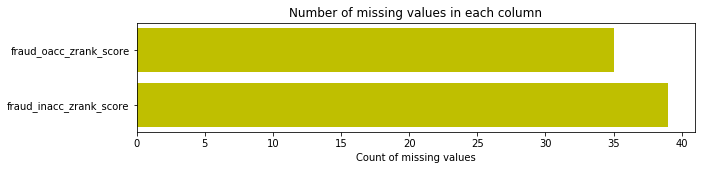

In [9]:
# 属性缺失情况
missing_df = total_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,2))
rects = ax.barh(ind, missing_df.missing_count.values, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

特征分析思路
- 整体数据所有特征的描述性分析
- 黑标/白标交易所有特征的描述性分析
- 黑标交易收款方所在交易（也作为收款方）/其他白标收款方的所有特征的描述性分析
- 特征热力图
- 划分收款方的特征和交易的特征

In [10]:
# 整体数据所有特征的描述性分析
# total_df.describe()

In [11]:
# 黑标交易所有特征的描述性分析
# fraud_event = total_df[total_df['flag_case']==1]
# print(fraud_event.shape)
# fraud_event.describe()

In [12]:
# print(fraud_event.describe().shape, fraud_event.shape)  # describe()的特征不包含字符串型的

In [13]:
# 白标交易所有特征的描述性分析
# white_event = total_df[total_df['flag_case']==0]
# print(white_event.shape)
# white_event.describe()

按收款方分组，分析对于同一个收款方，哪些特征不变。

In [14]:
# fix_feature_number = total_df.groupby('opposing_id').nunique()
# print(fix_feature_number.shape)
# fix_feature_number.to_csv('./fix_feature_number.csv')

选出含有inacc, opp, var, align_marker, score的特征

In [15]:
def select_features(features):
    opp_features = []
    pattern1 = re.compile('(\w*?)opp(\w*?)')
    pattern2 = re.compile('(\w*?)usr(\w*?)')
    pattern3 = re.compile('(\w*?)inacc(\w*?)')
    pattern4 = re.compile('(\w*?)oacc(\w*?)')
    pattern5 = re.compile('var(\w*?)')
    for feature in features:
        if feature in ['user_id', 'flag_case', 'align_marker', 'score']:
            opp_features.append(feature)
        elif pattern1.search(feature) or pattern3.search(feature):
            if pattern2.search(feature) is None and pattern4.search(feature) is None:
                opp_features.append(feature)
        elif pattern5.match(feature):
            opp_features.append(feature)
    return opp_features

In [16]:
selected_features = select_features(total_df.columns)

In [17]:
preprocess_df = total_df[selected_features]

In [18]:
print(preprocess_df.shape)
preprocess_df.head()

(294341, 187)


,user_id,opposing_id,flag_case,fraud_inacc_bhvior_black_envi_15d_flag,fraud_inacc_bhvior_cert_complain_cnt_30d,fraud_inacc_bhvior_complain_cnt_offline_45d,fraud_inacc_bhvior_complain_cnt_45d,fraud_inacc_bhvior_yeb_benefit_high_flag,fraud_inacc_prop_enterprise_auth_flag,fraud_inacc_prop_fengyun_hrisk_company_glist_flag,fraud_inacc_prop_good_offline_flag,fraud_inacc_prop_prop_batch_co_glist_lvl3_flag,fraud_inacc_zrank_score,fraud_inacc_prop_zrank_score_high_flag,fraud_inacc_sdm_amt_1d_90d,fraud_inacc_pay_gp_amt_1d_90d,fraud_inacc_mob_leidian_glist_lvl,fraud_inacc_leidian_glist_lvl,fraud_inacc_cert_leidian_glist_lvl,fraud_inacc_gp_day_cnt_1d_90d,fraud_inacc_rcv_acc_cnt_1d,fraud_inacc_rcv_cnt_2d_90d,fraud_inacc_rcv_cnt_1d,fraud_inacc_gp_cnt_3d_90d,fraud_inacc_rcv_day_cnt_90d,fraud_inacc_rcv_acc_prov_cnt_1d,fraud_inacc_str_glist_lvl,fraud_inacc_prop_reg_less_30d_flag,fraud_inaccorpeer_bhvior_gporxyk_90d,fraud_inacc_prop_auth_more_90d_flag,fraud_inacc_balance_amt_cent,fraud_inacc_prop_bd_merchant_flag,fraud_inacc_bhvior_low_risk_flag,fraud_inacc_prop_related_acc_cnt_co,fraud_inacc_prop_complain_immune_list_flag,fraud_inacc_bhvior_rcv_amt_ave_2d_90d,fraud_inacc_model_custseg,fraud_inacc_prop_reg_less_90d_flag,fraud_inacc_incard_bhvior_hquality_flag,fraud_inacc_bhvior_nokx_login_cnt_3h,fraud_inacc_certno_first_6,fraud_inacc_login_ipcountry_last_3d,fraud_inacc_model_all_custseg_flag,fraud_inacc_phone_score_lstm,fraud_inacc_antifrd_report_glist_opposing_phone_lvl,fraud_inacc_prop_related_acc_cnt,fraud_inacc_bhvior_loan_cnt_sum_wsd_mod_8h,fraud_inacc_fptx_cnt_6h,fraud_inacc_income_memo_cnt_1d,fraud_inacc_income_memo_amt_5mi,fraud_inacc_income_memo_amt_1d,fraud_inacc_income_memo_amt_7d,fraud_inacc_income_memo_amt_avg_5mi,fraud_inacc_income_memo_amt_avg_1d,fraud_inacc_bhvior_check_zhima_cnt_3h,fraud_inacc_bhvior_check_zhima_cnt_6h,fraud_inacc_bhivor_fp_rcv_avg_1d,fraud_inacc_bhvior_fp_rcv_amt_1d,fraud_inacc_bhvior_fp_rcv_amt_7d,fraud_inacc_bhivor_fp_rcv_avg_7d,fraud_inacc_bhivor_fp_rcv_cnt_7d,fraud_inacc_bhivor_fp_rcv_cnt_1d,fraud_inacc_bhvior_yeb_assets_avg_amt_7d,fraud_inacc_bhivor_fp_rcv_avg_1d_7d,fraud_inacc_prop_primary_acc_flag,fraud_inacc_bhvior_yeb_benefit_amt,fraud_inacc_last_login_ip3_is_iot_ip,fraud_inacc_bhivor_fp_rcv_avg_3d_7d,fraud_inacc_login_envi_cnt_6h,fraud_inacc_bhvior_black_envi_15d_flag_2,fraud_inacc_bhvior_nokx_login_cnt_6h,fraud_inacc_prop_thunder_rgl_gamble_lvl,fraud_inacc_prop_g_mer_all_user_list_lvl,fraud_inacc_bhvior_virtual_buy_cnt_7d,fraud_inacc_ledidian_leackage_uid_glist_lvl,fraud_inacc_gambler_glist_lvl,fraud_inacc_bhvior_taobao_telefare_cnt_1d_7d,fraud_inacc_bhvior_taobao_telefare_amt_1d_7d,fraud_inacc_bhvior_taobao_telefare_amt_1d_90d,fraud_inacc_bhvior_taobao_telefare_cnt_1d_90d,fraud_inacc_bhvior_phcarddpst_cnt_7d,fraud_inacc_bhvior_phcarddpst_amt_7d,fraud_inacc_login_country_lbs_3d,fraud_inacc_ugc_hrisk_glist_lvl,fraud_inacc_bhavior_non_credible_login_6h,fraud_inacc_bhavior_non_credible_login_7d,fraud_inacc_bhvior_taobao_telefare_cnt_1d_30d,fraud_inacc_bhvior_taobao_telefare_amt_1d_30d,fraud_inacc_bhvior_received_fund_from_gambler_distinct_cnt_7d,fraud_inacc_bhvir_iot_ip_3d,fraud_inacc_bhvir_iot_ip_1d,fraud_inacc_opp_user_list_auto_record_gamb_lvl1,fraud_inacc_prop_fund_uid_wp_fp_all_lvl1,fraud_inacc_prop_gamble_user_top_list_lvl1,fraud_inacc_bhvior_received_fund_from_gambler_sum_amt_7d,fraud_inacc_multi_login_envi_flag_1d,fraud_inacc_prop_gamble_fp_grey_dealer_lvl,fraud_inacc_fp_model_score_high_amt_max_7d,fraud_inacc_fp_model_score_high_cnt_7d,model_oppos_income_naccucnt_6h,model_opps_prnobat_cnt_1d,model_oppos_actbad_cnt_1d,model_opp_setblk_cnt_3d,model_opp_payinc_time_diff,opp_pay_cnt_rt,opp_swop_cnt_1d,var_171,var_172,opp_frd_prob_d,opprpc4,opprpc1,opposing_id_dt_distinct_e_6h,opps_trd_gpcnt_30d,oppo_reg_rt,opps_ph_cnt,model_oppos_fz_cnt_r_1d,opp_certl_ucnt,opp_fr_cnt,oppo_sm_amt_user_cnt_7d_new,c_opps_income_3d_certcitycnt,opp_trd_dd_90d,opp_avg_pay_cnt_90d,oppcert_incomets_15d_cnt_r_dd,model_opp_

缺失值、异常值处理

In [19]:
preprocess_df = preprocess_df.drop(['c_opp_user_create_day', 'opp_opp_mod_payinc_moda'], axis=1)
print(preprocess_df.shape)

(294341, 185)


onehot处理、连续值截断处理（或者离散化）【干脆不在一个小范围内的连续值属性都不要了】

step1: 删除一些特征

In [20]:
deleted_features = ['fraud_inacc_bhvior_complain_cnt_offline_45d', 'fraud_inacc_prop_auth_more_90d_flag', 
                    'fraud_inacc_prop_reg_less_90d_flag', 'fraud_inacc_certno_first_6', 
                    'fraud_inacc_antifrd_report_glist_opposing_phone_lvl', 'fraud_inacc_ugc_hrisk_glist_lvl', 
                    'fraud_inacc_opp_user_list_auto_record_gamb_lvl1', 'fraud_inacc_prop_fund_uid_wp_fp_all_lvl1', 
                    'fraud_inacc_prop_gamble_user_top_list_lvl1', 'fraud_inacc_prop_gamble_fp_grey_dealer_lvl', 'opp_overdue_flag']

In [21]:
preprocess_df = preprocess_df.drop(deleted_features, axis=1)
print(preprocess_df.shape)

(294341, 174)


step2: 截断归一化

In [22]:
def series_clip(features, low, high):
    for feature in features:
        print(feature)
        preprocess_df[feature] = np.clip(preprocess_df[feature], low, high)
        preprocess_df[feature] = (preprocess_df[feature]-preprocess_df[feature].min())/(preprocess_df[feature].max()-preprocess_df[feature].min())

- 0-1截断

In [23]:
features_clip_0_1 = [
    'model_opp_income_newsell_cnt15d_rt',
    'model_opp_income_creuid_cnt7d_rt',
    'opp_asset_rt',
    'model_opp_pay_fp_cnt_rt_90d',
    'model_opp_pay_cre_cnt_rt_90d',
    'model_opp_pay_tb_cnt_rt_90d',
    'model_oppos_income_nmatcnt_rt_6h',
    'oppcard_phn_city_rate',
    'oppo_age_rt',
    'model_oppos_pay_fnd_cnt_rt_90d',
    'opp_income_undefm_cnt_rt_1d',
    'oppo_reg_rt'
]

In [24]:
series_clip(features_clip_0_1, 0, 1)

model_opp_income_newsell_cnt15d_rt
model_opp_income_creuid_cnt7d_rt
opp_asset_rt
model_opp_pay_fp_cnt_rt_90d
model_opp_pay_cre_cnt_rt_90d
model_opp_pay_tb_cnt_rt_90d
model_oppos_income_nmatcnt_rt_6h
oppcard_phn_city_rate
oppo_age_rt
model_oppos_pay_fnd_cnt_rt_90d
opp_income_undefm_cnt_rt_1d
oppo_reg_rt


- 其他截断

In [25]:
series_clip(['fraud_inacc_sdm_amt_1d_90d', 'fraud_inacc_pay_gp_amt_1d_90d'], 0, 1e4)
series_clip(['fraud_inacc_income_memo_amt_7d'], 0, 5e6)
series_clip(['fraud_inacc_bhivor_fp_rcv_avg_1d'], 0, 4e5)
series_clip(['fraud_inacc_bhvior_fp_rcv_amt_1d'], 0, 5e6)
series_clip(['fraud_inacc_bhvior_yeb_assets_avg_amt_7d'], 0, 750000)
series_clip(['fraud_inacc_bhvior_yeb_benefit_amt'], 0, 2000)
series_clip(['fraud_inacc_bhivor_fp_rcv_avg_3d_7d'], 0, 3e5)
series_clip(['fraud_inacc_bhvior_received_fund_from_gambler_sum_amt_7d'], 0, 4e6)
series_clip(['opp_avg_pay_cnt_90d'], 0, 1500)
series_clip(['model_acc_opp_amt_rt_7d', 'opp_income_undefm_amt_rt_1d'], 0, 2e6)
series_clip(['model_oppos_asset_lev_rt'], 0, 2)
series_clip(['model_opp_lbsprovpay_cnt_30d'], 0, 7500)
series_clip(['model_opp_yeb_avgamt_7d'], 0, 750000)
series_clip(['opp_income_amt_rt'], 0, 2e7)
series_clip(['model_oppos_income_nacccnt_rt_6h'], 0, 1.5)
series_clip(['c_opp_outin_rt_1d'], 0, 4e6)
series_clip(['model_opp_payinc_time_diff'], 0, 86000)
series_clip(['opp_pay_amt_rt'], 0, 1e7)

fraud_inacc_sdm_amt_1d_90d
fraud_inacc_pay_gp_amt_1d_90d
fraud_inacc_income_memo_amt_7d
fraud_inacc_bhivor_fp_rcv_avg_1d
fraud_inacc_bhvior_fp_rcv_amt_1d
fraud_inacc_bhvior_yeb_assets_avg_amt_7d
fraud_inacc_bhvior_yeb_benefit_amt
fraud_inacc_bhivor_fp_rcv_avg_3d_7d
fraud_inacc_bhvior_received_fund_from_gambler_sum_amt_7d
opp_avg_pay_cnt_90d
model_acc_opp_amt_rt_7d
opp_income_undefm_amt_rt_1d
model_oppos_asset_lev_rt
model_opp_lbsprovpay_cnt_30d
model_opp_yeb_avgamt_7d
opp_income_amt_rt
model_oppos_income_nacccnt_rt_6h
c_opp_outin_rt_1d
model_opp_payinc_time_diff
opp_pay_amt_rt


step3: 众数填补

In [26]:
features_fillna = [
    'fraud_inacc_bhvior_yeb_benefit_high_flag',
    'fraud_inacc_prop_enterprise_auth_flag',
    'fraud_inacc_prop_fengyun_hrisk_company_glist_flag',
    'fraud_inacc_zrank_score',
    'fraud_inacc_mob_leidian_glist_lvl',
    'fraud_inacc_leidian_glist_lvl',
    'fraud_inacc_cert_leidian_glist_lvl',
    'fraud_inacc_str_glist_lvl',
    'fraud_inacc_prop_bd_merchant_flag',
    'fraud_inacc_model_custseg',
    'fraud_inacc_login_ipcountry_last_3d',
    'fraud_inacc_model_all_custseg_flag',
    'fraud_inacc_phone_score_lstm',
    'fraud_inacc_bhvior_loan_cnt_sum_wsd_mod_8h',
    'fraud_inacc_income_memo_amt_avg_5mi',
    'fraud_inacc_income_memo_amt_avg_1d',
    'fraud_inacc_bhivor_fp_rcv_avg_7d',
    'fraud_inacc_bhivor_fp_rcv_avg_1d_7d',
    'fraud_inacc_prop_primary_acc_flag',
    'fraud_inacc_last_login_ip3_is_iot_ip',
    'fraud_inacc_login_country_lbs_3d',
    'opp_pay_cnt_rt',
    'opp_frd_prob_d',
    'opps_ph_cnt',
    'model_oppos_fz_cnt_r_1d',
    'model_opp_activity_level',
    'opp_income_ucnt_rt',
    'opp_iden_total_score_d',
    'model_opps_device_30d_cnt',
    'opps_trd_30d_typecnt',
    'opp_user_cert_days',
    'ind_opp_city',
    'opp_asset_amt_d',
    'opp_acct_value_d'
]

In [27]:
def fill_na_majority(features):
    for feature in features:
        print(feature)
        if feature == 'fraud_inacc_zrank_score':
            preprocess_df[feature].fillna(preprocess_df[feature].mode()[0], inplace=True)
        else:
            temp = preprocess_df[feature]
            if feature in ['fraud_inacc_login_ipcountry_last_3d', 'fraud_inacc_login_country_lbs_3d']:
                majority = temp[temp!='unknown'].mode()[0]
            else:
                majority = temp[(temp!=-100) & (temp!=-99) & (temp!=-98) & (temp!=-10) & (temp!=-1)].mode()[0]
            temp[(temp==-100) | (temp==-99) | (temp==-98) | (temp==-10) | (temp==-1)] = majority  # preprocess_df会同时改变

In [28]:
fill_na_majority(features_fillna)

fraud_inacc_bhvior_yeb_benefit_high_flag


d:\applications\anaconda\envs\python-tf\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


fraud_inacc_prop_enterprise_auth_flag
fraud_inacc_prop_fengyun_hrisk_company_glist_flag
fraud_inacc_zrank_score
fraud_inacc_mob_leidian_glist_lvl
fraud_inacc_leidian_glist_lvl
fraud_inacc_cert_leidian_glist_lvl
fraud_inacc_str_glist_lvl
fraud_inacc_prop_bd_merchant_flag
fraud_inacc_model_custseg
fraud_inacc_login_ipcountry_last_3d
fraud_inacc_model_all_custseg_flag
fraud_inacc_phone_score_lstm
fraud_inacc_bhvior_loan_cnt_sum_wsd_mod_8h
fraud_inacc_income_memo_amt_avg_5mi
fraud_inacc_income_memo_amt_avg_1d
fraud_inacc_bhivor_fp_rcv_avg_7d
fraud_inacc_bhivor_fp_rcv_avg_1d_7d
fraud_inacc_prop_primary_acc_flag
fraud_inacc_last_login_ip3_is_iot_ip
fraud_inacc_login_country_lbs_3d
opp_pay_cnt_rt
opp_frd_prob_d
opps_ph_cnt
model_oppos_fz_cnt_r_1d
model_opp_activity_level
opp_income_ucnt_rt
opp_iden_total_score_d
model_opps_device_30d_cnt
opps_trd_30d_typecnt
opp_user_cert_days
ind_opp_city
opp_asset_amt_d
opp_acct_value_d


step4: 归一化

In [29]:
features_scale = [
    'fraud_inacc_bhvior_cert_complain_cnt_30d',
    'fraud_inacc_bhvior_complain_cnt_45d',
    'fraud_inacc_gp_day_cnt_1d_90d',
    'fraud_inacc_rcv_acc_cnt_1d',
    'fraud_inacc_rcv_cnt_2d_90d',
    'fraud_inacc_rcv_cnt_1d',
    'fraud_inacc_gp_cnt_3d_90d',
    'fraud_inacc_rcv_day_cnt_90d',
    'fraud_inacc_rcv_acc_prov_cnt_1d',
    'fraud_inacc_prop_related_acc_cnt_co',
    'fraud_inacc_bhvior_nokx_login_cnt_3h',
    'fraud_inacc_prop_related_acc_cnt',
    'fraud_inacc_fptx_cnt_6h',
    'fraud_inacc_income_memo_cnt_1d',
    'fraud_inacc_income_memo_amt_5mi',
    'fraud_inacc_income_memo_amt_1d',
    'fraud_inacc_income_memo_amt_avg_5mi',
    'fraud_inacc_income_memo_amt_avg_1d',
    'fraud_inacc_bhvior_check_zhima_cnt_3h',
    'fraud_inacc_bhvior_check_zhima_cnt_6h',
    'fraud_inacc_bhvior_fp_rcv_amt_7d',
    'fraud_inacc_bhivor_fp_rcv_avg_7d',
    'fraud_inacc_bhivor_fp_rcv_cnt_7d',
    'fraud_inacc_bhivor_fp_rcv_cnt_1d',
    'fraud_inacc_bhivor_fp_rcv_avg_1d_7d',
    'fraud_inacc_bhvior_nokx_login_cnt_6h',
    'fraud_inacc_bhvior_virtual_buy_cnt_7d',
    'fraud_inacc_bhvior_taobao_telefare_cnt_1d_7d',
    'fraud_inacc_bhvior_taobao_telefare_amt_1d_7d',
    'fraud_inacc_bhvior_taobao_telefare_amt_1d_90d',
    'fraud_inacc_bhvior_taobao_telefare_cnt_1d_90d',
    'fraud_inacc_bhvior_phcarddpst_cnt_7d',
    'fraud_inacc_bhvior_phcarddpst_amt_7d',
    'fraud_inacc_bhavior_non_credible_login_6h',
    'fraud_inacc_bhavior_non_credible_login_7d',
    'fraud_inacc_bhvior_taobao_telefare_cnt_1d_30d',
    'fraud_inacc_bhvior_taobao_telefare_amt_1d_30d',
    'fraud_inacc_bhvir_iot_ip_3d',
    'fraud_inacc_bhvir_iot_ip_1d',
    'fraud_inacc_fp_model_score_high_amt_max_7d',
    'fraud_inacc_fp_model_score_high_cnt_7d',
    'model_oppos_income_naccucnt_6h',
    'model_opps_prnobat_cnt_1d',
    'model_oppos_actbad_cnt_1d',
    'model_opp_setblk_cnt_3d',
    'opp_pay_cnt_rt',
    'opp_swop_cnt_1d',
    'opprpc4',
    'opprpc1',
    'opposing_id_dt_distinct_e_6h',
    'opps_trd_gpcnt_30d',
    'opps_ph_cnt',
    'opp_certl_ucnt',
    'opp_fr_cnt',
    'oppo_sm_amt_user_cnt_7d_new',
    'c_opps_income_3d_certcitycnt',
    'opp_trd_dd_90d',
    'oppcert_incomets_15d_cnt_r_dd',
    'model_opp_avg_payamt_90d',
    'model_opp_income_creuid_cnt7d',
    'model_opp_activity_level',
    'model_opp_zm_score',
    'opps_trd_xykcnt_30d',
    'opp_bind_cc_card_cnt',
    'opp_income_ucnt_rt',
    'opprpc7',
    'model_opprpc_6',
    'model_opp_lbsprov_inc_dt_30d',
    'model_opp_income_lbsprov_cnt_30d',
    'model_opp_income_stdamt_7d',
    'model_opps_income_cnt_1d',
    'model_opps_device_30d_cnt',
    'model_oppphn_reped_cnt_30d',
    'model_opp_complaint_social_cnt_7d',
    'model_opp_setinf_cnt_30d',
    'model_opp_soced_cnt_1d',
    'model_opp_scan_cnt_7d',
    'opprpc3',
    'opps_trd_30d_typecnt',
    'opprpc2',
    'opp_user_cert_days',
    'opps_income_1d_ucnt',
    'c_oppo_balance',
    'opp_avg_income_cnt_60d',
    'opp_asset_amt_d',
    'c_oppo_audit_link_30d',
    'c_opp_card_cnt',
    'opprpc5',
    'opprpc9'
]

In [30]:
def maxminscale(features):
    for feature in features:
        print(feature)
        preprocess_df[feature] = (preprocess_df[feature] - preprocess_df[feature].min()) / (preprocess_df[feature].max() - preprocess_df[feature].min())

In [31]:
maxminscale(features_scale)

fraud_inacc_bhvior_cert_complain_cnt_30d
fraud_inacc_bhvior_complain_cnt_45d
fraud_inacc_gp_day_cnt_1d_90d
fraud_inacc_rcv_acc_cnt_1d
fraud_inacc_rcv_cnt_2d_90d
fraud_inacc_rcv_cnt_1d
fraud_inacc_gp_cnt_3d_90d
fraud_inacc_rcv_day_cnt_90d
fraud_inacc_rcv_acc_prov_cnt_1d
fraud_inacc_prop_related_acc_cnt_co
fraud_inacc_bhvior_nokx_login_cnt_3h
fraud_inacc_prop_related_acc_cnt
fraud_inacc_fptx_cnt_6h
fraud_inacc_income_memo_cnt_1d
fraud_inacc_income_memo_amt_5mi
fraud_inacc_income_memo_amt_1d
fraud_inacc_income_memo_amt_avg_5mi
fraud_inacc_income_memo_amt_avg_1d
fraud_inacc_bhvior_check_zhima_cnt_3h
fraud_inacc_bhvior_check_zhima_cnt_6h
fraud_inacc_bhvior_fp_rcv_amt_7d
fraud_inacc_bhivor_fp_rcv_avg_7d
fraud_inacc_bhivor_fp_rcv_cnt_7d
fraud_inacc_bhivor_fp_rcv_cnt_1d
fraud_inacc_bhivor_fp_rcv_avg_1d_7d
fraud_inacc_bhvior_nokx_login_cnt_6h
fraud_inacc_bhvior_virtual_buy_cnt_7d
fraud_inacc_bhvior_taobao_telefare_cnt_1d_7d
fraud_inacc_bhvior_taobao_telefare_amt_1d_7d
fraud_inacc_bhvior_taobao_

step5: onehot

In [32]:
features_onehot = [
    'fraud_inacc_prop_fengyun_hrisk_company_glist_flag',
    'fraud_inacc_zrank_score',
    'fraud_inacc_mob_leidian_glist_lvl',
    'fraud_inacc_leidian_glist_lvl',
    'fraud_inacc_cert_leidian_glist_lvl',
    'fraud_inacc_str_glist_lvl',
    'fraud_inacc_model_custseg',
    'fraud_inacc_login_ipcountry_last_3d',
    'fraud_inacc_model_all_custseg_flag',
    'fraud_inacc_phone_score_lstm',
    'fraud_inacc_bhvior_loan_cnt_sum_wsd_mod_8h',
    'fraud_inacc_last_login_ip3_is_iot_ip',
    'fraud_inacc_login_country_lbs_3d',
    'fraud_inacc_bhvior_received_fund_from_gambler_distinct_cnt_7d',
    'opp_frd_prob_d',
    'opp_iden_total_score_d',
    'opp_acct_value_d'
]

In [33]:
def onehot(df, features):
    for feature in features:
        print(feature, df[feature].nunique())
        df[feature] = df[feature].apply(str)
        onehot_series = pd.get_dummies(df[feature], prefix=feature)
        df.drop([feature], axis=1, inplace=True)
        df = pd.concat([df, onehot_series], axis=1)
    return df

In [34]:
preprocess_df = onehot(preprocess_df, features_onehot)

fraud_inacc_prop_fengyun_hrisk_company_glist_flag 3
fraud_inacc_zrank_score 9
fraud_inacc_mob_leidian_glist_lvl 4
fraud_inacc_leidian_glist_lvl 3
fraud_inacc_cert_leidian_glist_lvl 3
fraud_inacc_str_glist_lvl 2
fraud_inacc_model_custseg 5
fraud_inacc_login_ipcountry_last_3d 65
fraud_inacc_model_all_custseg_flag 10
fraud_inacc_phone_score_lstm 6
fraud_inacc_bhvior_loan_cnt_sum_wsd_mod_8h 5
fraud_inacc_last_login_ip3_is_iot_ip 3
fraud_inacc_login_country_lbs_3d 57
fraud_inacc_bhvior_received_fund_from_gambler_distinct_cnt_7d 3
opp_frd_prob_d 3
opp_iden_total_score_d 4
opp_acct_value_d 3


In [35]:
preprocess_df.shape

(294341, 345)

step6: 特殊处理

In [36]:
def binary(feature, alpha):
    preprocess_df[feature] = preprocess_df[feature].apply(lambda x: 1 if x >= alpha else 0)

In [37]:
binary('fraud_inacc_balance_amt_cent', 1e9)
binary('fraud_inacc_bhvior_rcv_amt_ave_2d_90d', 2e5)
binary('opps_device_30d_maxuser', 4e7)

存点表

In [38]:
preprocess_df.head()

,user_id,opposing_id,flag_case,fraud_inacc_bhvior_black_envi_15d_flag,fraud_inacc_bhvior_cert_complain_cnt_30d,fraud_inacc_bhvior_complain_cnt_45d,fraud_inacc_bhvior_yeb_benefit_high_flag,fraud_inacc_prop_enterprise_auth_flag,fraud_inacc_prop_good_offline_flag,fraud_inacc_prop_prop_batch_co_glist_lvl3_flag,fraud_inacc_prop_zrank_score_high_flag,fraud_inacc_sdm_amt_1d_90d,fraud_inacc_pay_gp_amt_1d_90d,fraud_inacc_gp_day_cnt_1d_90d,fraud_inacc_rcv_acc_cnt_1d,fraud_inacc_rcv_cnt_2d_90d,fraud_inacc_rcv_cnt_1d,fraud_inacc_gp_cnt_3d_90d,fraud_inacc_rcv_day_cnt_90d,fraud_inacc_rcv_acc_prov_cnt_1d,fraud_inacc_prop_reg_less_30d_flag,fraud_inaccorpeer_bhvior_gporxyk_90d,fraud_inacc_balance_amt_cent,fraud_inacc_prop_bd_merchant_flag,fraud_inacc_bhvior_low_risk_flag,fraud_inacc_prop_related_acc_cnt_co,fraud_inacc_prop_complain_immune_list_flag,fraud_inacc_bhvior_rcv_amt_ave_2d_90d,fraud_inacc_incard_bhvior_hquality_flag,fraud_inacc_bhvior_nokx_login_cnt_3h,fraud_inacc_prop_related_acc_cnt,fraud_inacc_fptx_cnt_6h,fraud_inacc_income_memo_cnt_1d,fraud_inacc_income_memo_amt_5mi,fraud_inacc_income_memo_amt_1d,fraud_inacc_income_memo_amt_7d,fraud_inacc_income_memo_amt_avg_5mi,fraud_inacc_income_memo_amt_avg_1d,fraud_inacc_bhvior_check_zhima_cnt_3h,fraud_inacc_bhvior_check_zhima_cnt_6h,fraud_inacc_bhivor_fp_rcv_avg_1d,fraud_inacc_bhvior_fp_rcv_amt_1d,fraud_inacc_bhvior_fp_rcv_amt_7d,fraud_inacc_bhivor_fp_rcv_avg_7d,fraud_inacc_bhivor_fp_rcv_cnt_7d,fraud_inacc_bhivor_fp_rcv_cnt_1d,fraud_inacc_bhvior_yeb_assets_avg_amt_7d,fraud_inacc_bhivor_fp_rcv_avg_1d_7d,fraud_inacc_prop_primary_acc_flag,fraud_inacc_bhvior_yeb_benefit_amt,fraud_inacc_bhivor_fp_rcv_avg_3d_7d,fraud_inacc_login_envi_cnt_6h,fraud_inacc_bhvior_black_envi_15d_flag_2,fraud_inacc_bhvior_nokx_login_cnt_6h,fraud_inacc_prop_thunder_rgl_gamble_lvl,fraud_inacc_prop_g_mer_all_user_list_lvl,fraud_inacc_bhvior_virtual_buy_cnt_7d,fraud_inacc_ledidian_leackage_uid_glist_lvl,fraud_inacc_gambler_glist_lvl,fraud_inacc_bhvior_taobao_telefare_cnt_1d_7d,fraud_inacc_bhvior_taobao_telefare_amt_1d_7d,fraud_inacc_bhvior_taobao_telefare_amt_1d_90d,fraud_inacc_bhvior_taobao_telefare_cnt_1d_90d,fraud_inacc_bhvior_phcarddpst_cnt_7d,fraud_inacc_bhvior_phcarddpst_amt_7d,fraud_inacc_bhavior_non_credible_login_6h,fraud_inacc_bhavior_non_credible_login_7d,fraud_inacc_bhvior_taobao_telefare_cnt_1d_30d,fraud_inacc_bhvior_taobao_telefare_amt_1d_30d,fraud_inacc_bhvir_iot_ip_3d,fraud_inacc_bhvir_iot_ip_1d,fraud_inacc_bhvior_received_fund_from_gambler_sum_amt_7d,fraud_inacc_multi_login_envi_flag_1d,fraud_inacc_fp_model_score_high_amt_max_7d,fraud_inacc_fp_model_score_high_cnt_7d,model_oppos_income_naccucnt_6h,model_opps_prnobat_cnt_1d,model_oppos_actbad_cnt_1d,model_opp_setblk_cnt_3d,model_opp_payinc_time_diff,opp_pay_cnt_rt,opp_swop_cnt_1d,var_171,var_172,opprpc4,opprpc1,opposing_id_dt_distinct_e_6h,opps_trd_gpcnt_30d,oppo_reg_rt,opps_ph_cnt,model_oppos_fz_cnt_r_1d,opp_certl_ucnt,opp_fr_cnt,oppo_sm_amt_user_cnt_7d_new,c_opps_income_3d_certcitycnt,opp_trd_dd_90d,opp_avg_pay_cnt_90d,oppcert_incomets_15d_cnt_r_dd,model_opp_avg_payamt_90d,model_opp_income_creuid_cnt7d,model_opp_income_newsell_cnt15d_rt,model_opp_activity_level,model_opp_income_creuid_cnt7d_rt,model_opp_zm_score,opps_trd_xykcnt_30d,opp_bind_cc_card_cnt,opp_income_ucnt_rt,opp_asset_rt,opps_device_30d_maxuser,opp_pay_amt_rt,opprpc7,model_acc_opp_amt_rt_7d,model_opprpc_6,model_opp_pay_fp_cnt_rt_90d,model_opp_pay_cre_cnt_rt_90d,model_opp_pay_tb_cnt_rt_90d,model_oppos_asset_lev_rt,opp_income_undefm_amt_rt_1d,opp_income_undefm_cnt_rt_1d,model_opp_lbsprovpay_cnt_30d,model_opp_lbsprov_inc_dt_30d,model_opp_income_lbsprov_cnt_30d,model_opp_income_stdamt_7d,model_oppos_income_nmatcnt_rt_6h,model_opps_income_cnt_1d,model_opps_device_30d_cnt,model_opp_yeb_avgamt_7d,model_opp_unactiv_ind_mod,fraud_opp_mob_frd_lstm_mod_glist_lvl,model_oppphn_reped_cnt_30d,model_opp_complaint_social_cnt_7d,model_opp_setinf_cnt_30d,model_opp_soced_cnt_1d,model_opp_scan_cnt_7d,opprpc3,opps_t

In [39]:
groupby_opp = preprocess_df.groupby('opposing_id').mean()

In [40]:
groupby_opp.head()

,flag_case,fraud_inacc_bhvior_black_envi_15d_flag,fraud_inacc_bhvior_cert_complain_cnt_30d,fraud_inacc_bhvior_complain_cnt_45d,fraud_inacc_bhvior_yeb_benefit_high_flag,fraud_inacc_prop_enterprise_auth_flag,fraud_inacc_prop_good_offline_flag,fraud_inacc_prop_prop_batch_co_glist_lvl3_flag,fraud_inacc_prop_zrank_score_high_flag,fraud_inacc_sdm_amt_1d_90d,fraud_inacc_pay_gp_amt_1d_90d,fraud_inacc_gp_day_cnt_1d_90d,fraud_inacc_rcv_acc_cnt_1d,fraud_inacc_rcv_cnt_2d_90d,fraud_inacc_rcv_cnt_1d,fraud_inacc_gp_cnt_3d_90d,fraud_inacc_rcv_day_cnt_90d,fraud_inacc_rcv_acc_prov_cnt_1d,fraud_inacc_prop_reg_less_30d_flag,fraud_inaccorpeer_bhvior_gporxyk_90d,fraud_inacc_balance_amt_cent,fraud_inacc_prop_bd_merchant_flag,fraud_inacc_bhvior_low_risk_flag,fraud_inacc_prop_related_acc_cnt_co,fraud_inacc_prop_complain_immune_list_flag,fraud_inacc_bhvior_rcv_amt_ave_2d_90d,fraud_inacc_incard_bhvior_hquality_flag,fraud_inacc_bhvior_nokx_login_cnt_3h,fraud_inacc_prop_related_acc_cnt,fraud_inacc_fptx_cnt_6h,fraud_inacc_income_memo_cnt_1d,fraud_inacc_income_memo_amt_5mi,fraud_inacc_income_memo_amt_1d,fraud_inacc_income_memo_amt_7d,fraud_inacc_income_memo_amt_avg_5mi,fraud_inacc_income_memo_amt_avg_1d,fraud_inacc_bhvior_check_zhima_cnt_3h,fraud_inacc_bhvior_check_zhima_cnt_6h,fraud_inacc_bhivor_fp_rcv_avg_1d,fraud_inacc_bhvior_fp_rcv_amt_1d,fraud_inacc_bhvior_fp_rcv_amt_7d,fraud_inacc_bhivor_fp_rcv_avg_7d,fraud_inacc_bhivor_fp_rcv_cnt_7d,fraud_inacc_bhivor_fp_rcv_cnt_1d,fraud_inacc_bhvior_yeb_assets_avg_amt_7d,fraud_inacc_bhivor_fp_rcv_avg_1d_7d,fraud_inacc_prop_primary_acc_flag,fraud_inacc_bhvior_yeb_benefit_amt,fraud_inacc_bhivor_fp_rcv_avg_3d_7d,fraud_inacc_login_envi_cnt_6h,fraud_inacc_bhvior_black_envi_15d_flag_2,fraud_inacc_bhvior_nokx_login_cnt_6h,fraud_inacc_prop_thunder_rgl_gamble_lvl,fraud_inacc_prop_g_mer_all_user_list_lvl,fraud_inacc_bhvior_virtual_buy_cnt_7d,fraud_inacc_ledidian_leackage_uid_glist_lvl,fraud_inacc_gambler_glist_lvl,fraud_inacc_bhvior_taobao_telefare_cnt_1d_7d,fraud_inacc_bhvior_taobao_telefare_amt_1d_7d,fraud_inacc_bhvior_taobao_telefare_amt_1d_90d,fraud_inacc_bhvior_taobao_telefare_cnt_1d_90d,fraud_inacc_bhvior_phcarddpst_cnt_7d,fraud_inacc_bhvior_phcarddpst_amt_7d,fraud_inacc_bhavior_non_credible_login_6h,fraud_inacc_bhavior_non_credible_login_7d,fraud_inacc_bhvior_taobao_telefare_cnt_1d_30d,fraud_inacc_bhvior_taobao_telefare_amt_1d_30d,fraud_inacc_bhvir_iot_ip_3d,fraud_inacc_bhvir_iot_ip_1d,fraud_inacc_bhvior_received_fund_from_gambler_sum_amt_7d,fraud_inacc_multi_login_envi_flag_1d,fraud_inacc_fp_model_score_high_amt_max_7d,fraud_inacc_fp_model_score_high_cnt_7d,model_oppos_income_naccucnt_6h,model_opps_prnobat_cnt_1d,model_oppos_actbad_cnt_1d,model_opp_setblk_cnt_3d,model_opp_payinc_time_diff,opp_pay_cnt_rt,opp_swop_cnt_1d,var_171,var_172,opprpc4,opprpc1,opposing_id_dt_distinct_e_6h,opps_trd_gpcnt_30d,oppo_reg_rt,opps_ph_cnt,model_oppos_fz_cnt_r_1d,opp_certl_ucnt,opp_fr_cnt,oppo_sm_amt_user_cnt_7d_new,c_opps_income_3d_certcitycnt,opp_trd_dd_90d,opp_avg_pay_cnt_90d,oppcert_incomets_15d_cnt_r_dd,model_opp_avg_payamt_90d,model_opp_income_creuid_cnt7d,model_opp_income_newsell_cnt15d_rt,model_opp_activity_level,model_opp_income_creuid_cnt7d_rt,model_opp_zm_score,opps_trd_xykcnt_30d,opp_bind_cc_card_cnt,opp_income_ucnt_rt,opp_asset_rt,opps_device_30d_maxuser,opp_pay_amt_rt,opprpc7,model_acc_opp_amt_rt_7d,model_opprpc_6,model_opp_pay_fp_cnt_rt_90d,model_opp_pay_cre_cnt_rt_90d,model_opp_pay_tb_cnt_rt_90d,model_oppos_asset_lev_rt,opp_income_undefm_amt_rt_1d,opp_income_undefm_cnt_rt_1d,model_opp_lbsprovpay_cnt_30d,model_opp_lbsprov_inc_dt_30d,model_opp_income_lbsprov_cnt_30d,model_opp_income_stdamt_7d,model_oppos_income_nmatcnt_rt_6h,model_opps_income_cnt_1d,model_opps_device_30d_cnt,model_opp_yeb_avgamt_7d,model_opp_unactiv_ind_mod,fraud_opp_mob_frd_lstm_mod_glist_lvl,model_oppphn_reped_cnt_30d,model_opp_complaint_social_cnt_7d,model_opp_setinf_cnt_30d,model_opp_soced_cnt_1d,model_opp_scan_cnt_7d,opprpc3,opps_trd_30d_typecnt,opp_i

In [41]:
groupby_opp['flag_case'].describe()

count    89374.000000
mean         0.000244
std          0.014249
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: flag_case, dtype: float64

In [42]:
groupby_opp['flag_case'] = groupby_opp['flag_case'].apply(lambda x: 0 if x == 0 else 1)

In [43]:
groupby_opp['flag_case'].describe()

count    89374.000000
mean         0.000392
std          0.019785
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: flag_case, dtype: float64

In [44]:
features = groupby_opp.values[:, 1:]
targets = groupby_opp.values[:, 0].reshape((-1,1))

In [45]:
fea_tar = np.concatenate((features, targets), axis=1)

In [46]:
fea_tar.shape

(89374, 343)

In [47]:
opp_number, fea_tar_number = fea_tar.shape

In [48]:
# 写入点表
with open('risk_day1.content', 'w') as f:
    for i in range(opp_number):
        f.write(groupby_opp.index[i]+','+",".join(map(str, fea_tar[i])))
        f.write('\n')
    for user_id in set(preprocess_df.user_id):
        if user_id not in groupby_opp.index:
            f.write(user_id + ',' + ",".join(['0' for j in range(fea_tar_number)]))
            f.write('\n')

In [49]:
# 写入边表
with open('risk_day1.cites', 'w') as f:
    for user_id, opp_id in set(zip(preprocess_df.user_id, preprocess_df.opposing_id)):
        f.write(user_id + ' ' + opp_id)
        f.write('\n')